In [2]:
import json
import cv2
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import scipy.spatial.transform as tf
import plotly.graph_objects as gobj
from functools import cache

def cached_imread(f, imread_flag=cv2.IMREAD_COLOR):
    @cache
    def impl(f, imread_flag=cv2.IMREAD_COLOR):
        ret = cv2.imread(f, imread_flag)
        assert ret is not None and ret.size, f"{f} is empty"
        if imread_flag == cv2.IMREAD_COLOR:
            ret = cv2.cvtColor(ret, cv2.COLOR_BGR2RGB)
        return ret
    return impl(f, imread_flag)

In [3]:
# nsa_3d_ns = np.array([
#     [-0.078125 , -0.1875   , -0.8261623],
#     [-0.078125 , -0.078125 , -0.8255522],
#     [ 0.046875 , -0.1875   , -0.82176167],
#     [ 0.046875 , -0.078125 , -0.8211517]
# ])
# nsa_3d_ns = np.array([
#     [-0.09375, -0.203125, -0.83986217],
#     [-0.09375, -0.0625,   -0.8418088 ],
#     [ 0.0625,  -0.203125, -0.8338717 ],
#     [ 0.0625,  -0.0625,   -0.83581835],
# ]) # new value from CS on Dec 11
nsa_3d_pc = np.array([
     [-0.734375,-0.171875,-0.34375 ],
     [-0.734375,-0.171875, 0.375   ],
     [-0.734375, 0.203125, 0.375   ],
     [-0.734375, 0.203125,-0.34375 ],
]) # distinguisher from CS on Dec 11
ds_len = 57
ds_path = "data/polycam_distinguisher"
#nsa_3d_pc = np.load(f"{ds_path}/eval_images/aabb_intersections.npy")
print(f"{nsa_3d_pc=}")

with open(f"{ds_path}/transforms.json", 'r') as f:
    transforms = json.load(f)
with open(f"{ds_path}/correct_c2w.json") as f:
    correct_c2w_json = json.load(f)

img_id_to_frame = {int(f["file_path"].split('_')[-1][:5]) : f for f in transforms["frames"]}
img_id_to_c2w = {int(f["file_path"].split('_')[-1][:5]) : f for f in correct_c2w_json["frames"]}

def to_2d(c2w: dict,
          p3d, # n*3
          distortion = None,
        ):
    fx = c2w["fx"]
    fy = c2w["fy"]
    cx = c2w["cx"]
    cy = c2w["cy"]
    K = np.array([
        [fx, 0, cx],
        [0, fy, cy],
        [0, 0,  1],
    ])
    T = np.array(c2w["transform_matrix"])
    w2c_R = T[:3, :3].T
    w2c_R[1:, :] *= -1 # flip y and z to match get_plane.py
    w2c_T = -w2c_R @ T[:3, -1]
    uv, _ = cv2.projectPoints(p3d, w2c_R, w2c_T, K, distortion)
    uv = uv.reshape((-1, 2))
    return uv

def dilate_mask(mask_img, radius, invert=False):
    filter = cv2.getStructuringElement(cv2.MORPH_RECT, ksize=(radius,radius))
    mask_img = np.bitwise_not(mask_img) if invert else mask_img
    dilated = cv2.dilate(
        mask_img, filter,
        #borderType=cv2.BORDER_CONSTANT, borderValue=255
    )
    # binarize
    dilated[dilated>0] = 255
    dilated[dilated!=255] = 0
    return dilated.astype(np.uint8)


def process_mate_image(img_id:int, save_masks=False):
    c2w = img_id_to_c2w[img_id]
    img_name = c2w['file_path']
    img_path = f"{ds_path}/images/{img_name.replace('jpg', 'png')}"
    img = cached_imread(img_path)
    obj_mask = cached_imread(f"{ds_path}/masks_2/frame_{img_id:05d}.png", cv2.IMREAD_GRAYSCALE) != 255
    uv = to_2d(c2w, nsa_3d_pc)
    nsa_mask = np.zeros_like(obj_mask, dtype=np.uint8)
    nsa_hull = cv2.convexHull(uv.astype(np.int32))
    cv2.fillPoly(nsa_mask, [nsa_hull], 255, cv2.LINE_AA)
    nsa_mask[nsa_mask>0] = 255
    nsa_mask[nsa_mask!=255] = 0
    dilated = dilate_mask(nsa_mask, radius=71)
    if save_masks:
        out_img_name = f"{ds_path}/masks_nsa/{img_name}"
        cv2.imwrite(out_img_name, nsa_mask)
        out_img_name = f"{ds_path}/masks_nsa_dilated/frame{img_id:05d}_mask001.png"
        cv2.imwrite(out_img_name, dilated)
    return img, obj_mask, nsa_mask, dilated 

for img_id in range(1, ds_len):
    process_mate_image(img_id, save_masks=True)
    pass
print("done")

# process_mate_image(1)
@interact(img_id = widgets.IntSlider(min=1, max=ds_len-1, step=1, value=1, continuous_update=False))
def mate_proc_demo(img_id:int, read_from_disk=False):
    print(f"{read_from_disk=}")
    try:
        if read_from_disk:
            c2w = img_id_to_c2w[img_id]
            img_name = c2w['file_path']
            img_path = f"{ds_path}/images_inpaint/{img_name}".replace("jpg", "png").replace("frame_", "frame")
            img = cached_imread(img_path)
            obj_mask = cached_imread(f"{ds_path}/masks_2/frame_{img_id:05d}.png", cv2.IMREAD_GRAYSCALE) != 255
            nsa_mask = cached_imread(f"{ds_path}/masks_nsa/frame_{img_id:05d}.png", cv2.IMREAD_GRAYSCALE)  # white is nsa
            nsa_dilated_mask = cached_imread(f"{ds_path}/masks_nsa_dilated/frame{img_id:05d}_mask001.png", cv2.IMREAD_GRAYSCALE)  # white is nsa
            #nsa_dilated_mask = dilate_mask(nsa_mask, radius=61)
        else:
            img, obj_mask, nsa_mask, nsa_dilated_mask = process_mate_image(img_id)
        #np.putmask(img[..., 1], nsa_mask, 255)  # red for object
        np.putmask(img[..., 2], nsa_dilated_mask - nsa_mask, 255) # blue for nsa dilation radius
        #np.putmask(img[..., 0], obj_mask & (obj_mask ^ nsa_dilated_mask), 255) # green for nsa
        plt.imshow(img)
        plt.show()
    except Exception as e:
        print(e)
        raise e

#mate_proc_demo(3)

nsa_3d_pc=array([[-0.734375, -0.171875, -0.34375 ],
       [-0.734375, -0.171875,  0.375   ],
       [-0.734375,  0.203125,  0.375   ],
       [-0.734375,  0.203125, -0.34375 ]])
done


interactive(children=(IntSlider(value=1, continuous_update=False, description='img_id', max=56, min=1), Checkb…

In [4]:
img_path = lambda i: f"{ds_path}/images_inpainted/{img_id_to_c2w[i]['file_path']}".replace(".png", '_mask001.png').replace("frame_", "frame")


def warp_patch(
    src_image,
    src_nsa_mask,
    dst_img,
    H, # 3*3 homography
):
    y, x = src_image.shape[:2]
    warped_src = cv2.warpPerspective(src_image, H, dsize=(x, y), flags=cv2.INTER_LANCZOS4) 
    warped_patch = warped_src.copy()
    warped_patch_mask = cv2.warpPerspective(src_nsa_mask, H, dsize=(x, y), flags=cv2.INTER_NEAREST) 
    cv2.threshold(warped_patch_mask, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    warped_patch[warped_patch_mask==0] = np.zeros((3,), dtype=np.uint8)
    warp_result_addition = dst_img.copy()
    warp_result_addition[warped_patch_mask==255] = warped_patch[warped_patch_mask==255]
    br = cv2.boundingRect(warped_patch_mask) # bounding rect (x,y,width,height)
    centerOfBR = (br[0] + br[2] // 2, br[1] + br[3] // 2)
    blend_input = dst_img.copy()
    #blend_input[warped_patch_mask!=0] = 0
    warp_result_blend = cv2.seamlessClone(warped_patch_mask, blend_input, warped_patch, centerOfBR, cv2.MIXED_CLONE)
    return warp_result_addition, warp_result_blend


def match_nsa_corners(
    src_img_id, dst_img_id,
    img_id_to_c2w=img_id_to_c2w,
    nsa_3d_pts=nsa_3d_pc,
):
    H, _ = cv2.findHomography(
        to_2d(img_id_to_c2w[src_img_id], nsa_3d_pts),
        to_2d(img_id_to_c2w[dst_img_id], nsa_3d_pts),
        method=0,
    )
    return H


def match_features(
    src_img, dst_img,
    src_mask, dst_mask
):
    orb = cv2.ORB_create()
    kp1, desc1 = orb.detectAndCompute(src_img, ~src_mask) # don't use features inside nsa
    kp2, desc2 = orb.detectAndCompute(dst_img, ~dst_mask)

    # orb descriptor is binary, use hamming dist
    matcher = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matches = matcher.match(desc1, desc2)
    matches = sorted(matches, key = lambda x:x.distance)[:len(matches)//10]

    H, _ = cv2.findHomography(
        np.float32([kp1[m.queryIdx].pt for m in matches]).reshape(-1,2),
        np.float32([kp2[m.trainIdx].pt for m in matches]).reshape(-1,2),
        cv2.USAC_PROSAC,
        3.0,
    )
    return H


def do_warp(
    src_img_id,
    src_img,
    src_nsa_mask,
    dst_img_id,
):
    #src_img = cached_imread(img_path(src_img_id))
    dst_img = cached_imread(img_path(dst_img_id))
    H = match_nsa_corners(src_img_id, dst_img_id)
    #H = match_features(src_img, dst_img, src_mask=src_nsa_mask, dst_mask=cached_imread(f"{ds_path}/masks_nsa/frame{dst_img_id:05d}_mask001.png", cv2.IMREAD_GRAYSCALE),)
    return warp_patch(
        src_img,
        src_nsa_mask,
        dst_img,
        H,
    )


def fixed_warp(
    dst_img_id: int,
    src_img_id = 1,
):
    return do_warp(
        src_img_id,
        cached_imread(img_path(src_img_id)),
        cached_imread(f"{ds_path}/masks_nsa/frame_{src_img_id:05d}.png", cv2.IMREAD_GRAYSCALE),
        dst_img_id,
    )

@cache
def sequential_warp(
    dst_img_id: int,
):
    def _impl(dst_img_id: int):
        src_img_id = dst_img_id - 1
        src_img = cached_imread(img_path(src_img_id)) if src_img_id == 1 else sequential_warp(src_img_id)[0]  # use add result
        warp_result_addition, warp_result_blend = do_warp(
            src_img_id,
            src_img,
            cached_imread(f"{ds_path}/masks_nsa/frame_{src_img_id:05d}.png", cv2.IMREAD_GRAYSCALE),
            dst_img_id, 
        )
        return warp_result_addition, warp_result_blend
    ret = _impl(dst_img_id)
    return ret

from PIL import Image
for i in range(2, ds_len):
    w, _ = sequential_warp(i) # warm cache
    Image.fromarray(w).save(f"/Users/bzs/Downloads/polycam_sculpture/images_warp_seq/frame_{i:05d}.png")
    #cv2.imwrite(f"/Users/bzs/Downloads/polycam_sculpture/images_warp_seq/frame_{i:05d}.png", w)
    
@interact(dst_img_id = widgets.IntSlider(min=2, max=ds_len, step=1, value=2, continuous_update=False))
def nsa_demo(
    dst_img_id: int,
):
    inpainted_dst = cached_imread(img_path(dst_img_id))
    fixed_add, fixed_blend = fixed_warp(dst_img_id, 1)
    seq_add, seq_blend = sequential_warp(dst_img_id)
    disp_img = np.vstack([
        np.hstack([inpainted_dst, fixed_blend]),
        np.hstack([seq_add, seq_blend]),
    ])
    plt.figure(figsize=(18, 18))
    plt.imshow(disp_img)
    plt.show()
#nsa_demo(2)

interactive(children=(IntSlider(value=2, continuous_update=False, description='dst_img_id', max=57, min=2), Ou…

In [54]:
from PIL import Image
for dst_img_id in range(2, 70):
    fixed_add, fixed_blend = fixed_warp(dst_img_id, 1)
    seq_add, seq_blend = sequential_warp(dst_img_id)
    Image.fromarray(fixed_blend).save(f"{ds_path}/images_warp_fixed/frame_{dst_img_id:05d}.png")
    Image.fromarray(seq_blend).save(f"{ds_path}/images_warp_seq/frame_{dst_img_id:05d}.png")
    

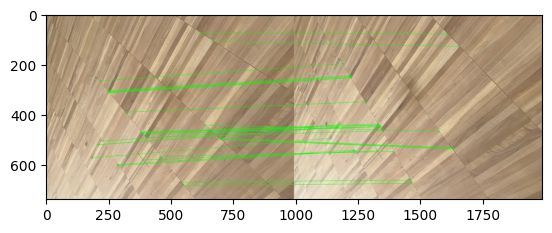

(<matplotlib.image.AxesImage at 0x16a08db40>, None)

In [92]:
src_img_id, dst_img_id  = 9, 10
src_img = cached_imread(img_path(src_img_id))
dst_img = cached_imread(img_path(dst_img_id))
src_mask= cached_imread(f"{ds_path}/masks_nsa/frame{src_img_id:05d}_mask001.png", cv2.IMREAD_GRAYSCALE)
dst_mask= cached_imread(f"{ds_path}/masks_nsa/frame{dst_img_id:05d}_mask001.png", cv2.IMREAD_GRAYSCALE)

orb = cv2.ORB_create()
kp1, desc1 = orb.detectAndCompute(src_img, ~src_mask) # don't use features inside nsa
kp2, desc2 = orb.detectAndCompute(dst_img, ~dst_mask)

# orb descriptor is binary, use hamming dist
matcher = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
matches = matcher.match(desc1, desc2)
matches = sorted(matches, key = lambda x:x.distance)[:len(matches)//10]

H, _ = cv2.findHomography(
    np.float32([kp1[m.queryIdx].pt for m in matches]).reshape(-1,2),
    np.float32([kp2[m.trainIdx].pt for m in matches]).reshape(-1,2),
    cv2.USAC_PROSAC,
    3.0,
)

h,w = src_img.shape[:-1]
pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
dst = cv2.perspectiveTransform(pts, H)
#dst_img = cv2.polylines(dst_img,[np.int32(dst)],True,255,3, cv2.LINE_AA)

img3 = cv2.drawMatches(src_img,kp1,dst_img,kp2,matches[:100],None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
#plt.figure(figsize=(10, 10))
draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                   singlePointColor = None,
                   matchesMask = None, # draw only inliers
                   flags = 2)
img3 = cv2.drawMatches(src_img,kp1,dst_img,kp2,matches,None,**draw_params)
plt.imshow(img3),plt.show()



In [60]:
import copy
t = copy.deepcopy(transforms)

for x in t["frames"]:
    del x["depth_file_path"]
    mp = x["file_path"]
    x["file_path"] = mp.replace("jpg", "png")
    mp = mp.replace("images/", "masks_2/").replace("frame_", "frame").replace(".jpg", "_mask001.png")
    x["mask_path"] = mp

with open("transforms.json", "w") as f:
    json.dump(t, f, indent=2)